### 数据处理

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import MCM

sum_days = 4
test_start = 4910
test_end = 5105 #Excel中的行数-2

data = pd.read_csv('./bigger_Wimbledon_featured_matches.csv')
num_data = data.copy()
num_data['elapsed_time'] = pd.to_timedelta(num_data['elapsed_time']).dt.total_seconds()
num_data['cost_time'] = num_data['elapsed_time'] - num_data['elapsed_time'].shift(1)
num_data['p1_get_point'] = (num_data['point_victor'] == 1).astype(int)
num_data['p2_get_point'] = (num_data['point_victor'] == 2).astype(int)
num_data['p1_score'] = num_data['p1_score'].apply(
    lambda x: 0 if x=='0' else
              1 if x=='15' else
              2 if x=='30' else
              3 if x=='40' else 4)#AD
num_data['p2_score'] = num_data['p2_score'].apply(
    lambda x: 0 if x=='0' else
              1 if x=='15' else
              2 if x=='30' else
              3 if x=='40' else 4)#AD
num_data['winner_shot_type'] = num_data['winner_shot_type'].apply(
    lambda x: -1 if x=='B' else
               1 if x=='F' else 0)#0
num_data['speed_mph'] = num_data['speed_mph'].apply(
    lambda x: x if x>=1 and x <= 300 else num_data['speed_mph'].mean())
num_data['serve_width_1'] = num_data['serve_width'].apply(
    lambda x: 1 if x=='BC' or x=='BW' or x=='B' else 0)#NA,C,W
num_data['serve_width_2'] = num_data['serve_width'].apply(
    lambda x: -1 if x=='BC' or x=='C' else
               1 if x=='BW' or x=='W' else 0)#NA,B
num_data['serve_depth'] = num_data['serve_depth'].apply(
    lambda x: -1 if x=='NCTL' else
               1 if x=='CTL'  else 0)#NA
num_data['return_depth'] = num_data['return_depth'].apply(
    lambda x: -1 if x=='ND' else
               1 if x=='D'  else 0)#NA
num_columns = num_data.columns.to_list()
num_columns.remove('match_id')
num_columns.remove('elapsed_time')
num_columns.remove('player1')
num_columns.remove('player2')
num_columns.remove('serve_width')
num_data = num_data[num_columns]

dict_data = MCM.load('./bigger-weight-save-2024-02-03-09-02-18.json')
dict_data['p1_m_avg'] = np.array(dict_data['p1_m_avg'])
dict_data['p2_m_avg'] = np.array(dict_data['p2_m_avg'])
dict_data['p1_m_gaussian'] = np.array(dict_data['p1_m_gaussian'])
dict_data['p2_m_gaussian'] = np.array(dict_data['p2_m_gaussian'])

train_data = num_data[0:test_end].copy()
for i in range(1,sum_days):
    train_data = train_data + num_data[i:test_end+i].reset_index(drop=True)
train_data['p1_m_avg'] = dict_data['p1_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p2_m_avg'] = dict_data['p2_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p1_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p2_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p1_next_m_avg'] = dict_data['p1_m_avg'][sum_days:test_end+sum_days]
train_data['p2_next_m_avg'] = dict_data['p2_m_avg'][sum_days:test_end+sum_days]
train_data['p1_next_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days:test_end+sum_days]
train_data['p2_next_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days:test_end+sum_days]
train_data['p1_avg_diff'] = dict_data['p1_m_avg'][sum_days:test_end+sum_days]-dict_data['p1_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p2_avg_diff'] = dict_data['p2_m_avg'][sum_days:test_end+sum_days]-dict_data['p2_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p1_gaussian_diff'] = dict_data['p1_m_gaussian'][sum_days:test_end+sum_days]-dict_data['p1_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p2_gaussian_diff'] = dict_data['p2_m_gaussian'][sum_days:test_end+sum_days]-dict_data['p2_m_gaussian'][sum_days-1:test_end+sum_days-1]
i = test_end-2
last_end = test_end-1
another_start= 2673
another_end = 2948
while i>=-1:
    if(i == test_start-1):
        use_data = train_data[test_start:].copy()
        use_data = use_data.reset_index(drop=True)
    if(i == another_start-1):
        another_data = train_data[another_start:another_end].copy()
        another_data = another_data.reset_index(drop=True)
    if i>=0:
        if data['match_id'][i]==data['match_id'][i+1]:
            i-=1
            continue
    last_start = i+1
    drop_list = list(range(last_start,last_start+sum_days-1)) 
    drop_list.append(last_end)
    train_data = train_data.drop(drop_list)
    i -= 1
    last_end = last_start-1

for i in range(0,another_data.shape[0]):
    if another_data['server'][i] != 0:
        another_data.loc[i, 'server'] = 3-another_data['server'][i]
    if another_data['point_victor'][i] != 0:
        another_data.loc[i, 'point_victor'] = 3-another_data['point_victor'][i]
    if another_data['game_victor'][i] != 0:
        another_data.loc[i, 'game_victor'] = 3-another_data['game_victor'][i]
    if another_data['set_victor'][i] != 0:
        another_data.loc[i, 'set_victor'] = 3-another_data['set_victor'][i]
another_columns = ['point_no','p2_sets','p1_sets','p2_games','p1_games','p2_score',
 'p1_score', 'server', 'serve_no' ,'point_victor' ,'p2_points_won',
 'p1_points_won', 'game_victor', 'set_victor' ,'p2_ace', 'p1_ace', 'p2_winner',
 'p1_winner' ,'winner_shot_type', 'p2_double_fault', 'p1_double_fault',
 'p2_unf_err' ,'p1_unf_err', 'p2_net_pt', 'p1_net_pt' ,'p2_net_pt_won',
 'p1_net_pt_won', 'p2_break_pt', 'p1_break_pt', 'p2_break_pt_won',
 'p1_break_pt_won' ,'p2_distance_run', 'p1_distance_run', 'rally_count',
 'speed_mph' ,'serve_depth' ,'return_depth', 'cost_time', 'serve_width_1',
 'serve_width_2']

from sklearn.preprocessing import MinMaxScaler
columns = use_data.columns.to_numpy()[:-12]
del_columns = ['set_no','game_no','p1_get_point','p2_get_point','p1_break_pt_missed','p2_break_pt_missed']
new_columns = columns[~np.isin(columns, del_columns)]
X = use_data[new_columns].to_numpy()
Y = use_data.iloc[:, -6:-4].to_numpy()
another_X = another_data[another_columns].to_numpy()
another_Y = another_data.iloc[:, -6:-4].to_numpy()
#将数据集交替划分为训练集和测试集，即奇数个样本为训练集，偶数个样本为测试集
X_train = np.array([x for i, x in enumerate(X) if i % 4 != 0])
X_test = np.array([x for i, x in enumerate(X) if i % 4 == 0])
y_train = np.array([y for i, y in enumerate(Y) if i % 4 != 0])
y_test = np.array([y for i, y in enumerate(Y) if i % 4 == 0])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=21624)

### 降维（因素重要性）

##### 随机森林

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=21624)
rf_regressor.fit(X_train, y_train)
y_test_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)
MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
print('MSE_train:',MSE_train)
print('RMSE:',np.sqrt(MSE_train))
print('MSE_test:',MSE_test)
print('RMSE:',np.sqrt(MSE_test))
feature_importance = list(zip(new_columns, rf_regressor.feature_importances_))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=False)
feature_importance = dict(feature_importance)
print(feature_importance.keys())

MSE_train: 0.013095728534268094
RMSE: 0.1144365699165616
MSE_test: 0.09106517530170583
RMSE: 0.301770070254997
dict_keys(['p2_break_pt', 'p1_double_fault', 'set_victor', 'p1_break_pt_won', 'p2_break_pt_won', 'p1_break_pt', 'p1_sets', 'p1_ace', 'p2_double_fault', 'p1_net_pt_won', 'p2_ace', 'p1_net_pt', 'p2_net_pt', 'p2_sets', 'p2_unf_err', 'serve_no', 'point_victor', 'p2_net_pt_won', 'game_victor', 'p1_unf_err', 'winner_shot_type', 'p2_winner', 'p1_winner', 'serve_width_2', 'serve_depth', 'server', 'serve_width_1', 'p2_score', 'rally_count', 'return_depth', 'p1_score', 'p2_points_won', 'p1_games', 'p1_points_won', 'point_no', 'speed_mph', 'cost_time', 'p2_distance_run', 'p2_games', 'p1_distance_run'])


##### 主成分分析（随机森林检验效果）

[0.91719231 0.99785419 0.99932622 0.99969439 0.99986085 0.99991378
 0.99995124 0.99996356 0.99997388 0.99998038 0.99998442 0.99998783
 0.99999065 0.9999927  0.99999421 0.99999529 0.99999607 0.99999673
 0.99999731 0.99999779 0.99999822 0.99999861 0.99999892 0.99999914
 0.99999932 0.99999946 0.99999957 0.99999967 0.99999975 0.99999981
 0.99999986 0.99999989 0.99999992 0.99999995 0.99999996 0.99999998
 0.99999999 1.         1.         1.        ]


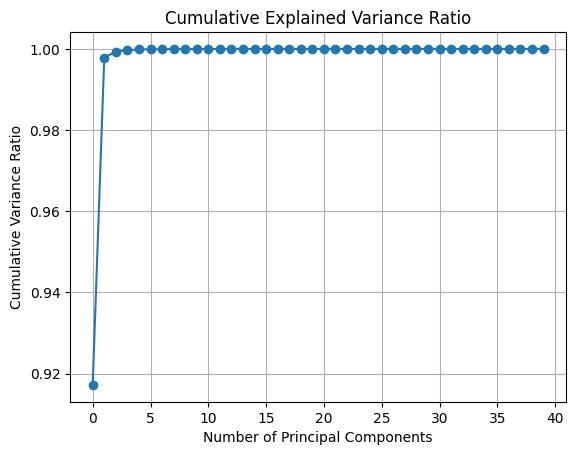

    point_no       p1_sets       p2_sets      p1_games      p2_games  \
0  -0.013147  4.372662e-05 -2.016689e-04 -2.831123e-04 -2.822479e-04   
1   0.811907  1.083764e-02  4.800898e-03  9.630848e-03 -3.790541e-03   
2   0.013904 -1.082630e-02  8.803840e-03  5.247509e-03  1.605957e-02   
3  -0.045797  3.757536e-02 -2.155864e-02 -8.041762e-02 -3.767007e-02   
4  -0.066800  7.830373e-02 -5.070075e-02 -1.240363e-01 -3.497250e-02   
5   0.009785  5.902045e-02  5.276846e-02 -5.486013e-01 -4.810127e-01   
6  -0.011963 -2.440998e-02 -6.342526e-02  4.548822e-01  4.368324e-01   
7   0.010728  1.060686e-01 -8.041356e-02 -2.849848e-01  4.919162e-01   
8  -0.008953 -1.441912e-01  1.305883e-01  5.700527e-01 -4.708736e-01   
9   0.001846  4.337625e-02 -4.647690e-04  6.164541e-02 -1.359386e-01   
10 -0.000051 -2.147104e-02  1.367931e-02  4.186120e-02  1.508813e-03   
11 -0.001996 -8.506392e-03 -3.780110e-02  1.496512e-02  7.155289e-02   
12 -0.000642 -2.687579e-02  2.124619e-02  6.008057e-02 -1.210003

In [7]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_ = X_train

# 初始化PCA模型，不指定降维后的维度
pca = PCA()

# 在数据上进行PCA变换
X_pca = pca.fit_transform(X_)

# 计算解释方差的累积百分比
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

# 绘制累积方差百分比曲线
print(explained_variance_ratio_cumsum)
plt.plot(explained_variance_ratio_cumsum, marker='o')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.show()
# 将主成分的矩阵转化为dataframe,加入列名并输出
df_pca = pd.DataFrame(pca.components_, columns=new_columns)
print(df_pca)

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#使用降维后的数据用随机森林回归，在主成分不足6个时，MSE大幅增加
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=21624)
rf_regressor.fit(X_train_pca, y_train)
y_test_pred = rf_regressor.predict(X_test_pca)
y_train_pred = rf_regressor.predict(X_train_pca)
MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
print('MSE_train:',MSE_train)
print('RMSE:',np.sqrt(MSE_train))
print('MSE_test:',MSE_test)
print('RMSE:',np.sqrt(MSE_test))

MSE_train: 0.014604510770442131
RMSE: 0.12084912399534442
MSE_test: 0.10041615840249679
RMSE: 0.3168850870623242


##### 逐个特征检验（随机森林检验效果）

In [9]:
#尝试逐个删去数据中的特征，观察MSE的变化（使用随机森林回归），判断特征的重要性，结果显示哪个都不重要
# now_column = train_data.columns.to_list()[:-12]
# sort_column = []
# now_train = X_train.copy()
# now_test = X_test.copy()
# for i in range(0, len(columns)):
#     pred_record = []
#     for i in range(0, len(now_column)):
#         temp_data = np.delete(now_train, now_column.index(now_column[i]), axis=1)
#         rf_regressor = RandomForestRegressor(n_estimators=100, random_state=21624)
#         rf_regressor.fit(temp_data, y_train)
#         y_train_pred = rf_regressor.predict(temp_data)
#         pred_record.append(mean_squared_error(y_train, y_train_pred))
#     min_index = pred_record.index(min(pred_record)) #找到MSE最小的特征，说明这个特征对模型的影响最小
#     now_train = np.delete(now_train, now_column.index(now_column[min_index]), axis=1)
#     now_test = np.delete(now_test, now_column.index(now_column[min_index]), axis=1)
#     rf_regressor = RandomForestRegressor(n_estimators=100, random_state=21624)
#     rf_regressor.fit(now_train, y_train)
#     y_test_pred = rf_regressor.predict(now_test)
#     sort_column.append(now_column[min_index])
#     print(pred_record)
#     print(now_column[min_index], min(pred_record), mean_squared_error(y_test, y_test_pred))
#     now_column.pop(min_index)
'''
[0.013538537214396408, 0.014026127408126397, 0.013818858621868048, 0.013999510773558654, 0.014109469016446302, 0.01349715427601703, 0.013759830105675835, 0.013433741120766748, 0.014079373882366766, 0.01400386253718481, 0.013815243032363114, 0.01400658154934024, 0.013688994926552307, 0.01381183311304727, 0.013750165559975219, 0.01366516513371706, 0.013756312097719551, 0.013719973409426593, 0.013975284953866188, 0.013566508048267593, 0.013905958447188772, 0.013653809385831703, 0.013773836841285957, 0.014040314716961997, 0.013481740941139114, 0.013745357922792793, 0.013782239395170964, 0.013841422417182033, 0.013825696671757533, 0.013598207661295169, 0.013736989682325052, 0.013496580316911005, 0.013710100828710572, 0.013816943837864396, 0.013525322542001398, 0.014033707884268155, 0.013412109332711804, 0.014144758463237084, 0.014161746233011266, 0.01401161755413964, 0.014433146125017105, 0.014147572930305649, 0.01379923646104704, 0.013744626584680404, 0.014025029246890206, 0.013378329894239309]
serve_width_2 0.013378329894239309 0.09895060830394024
[0.013684817661459323, 0.013619239895481966, 0.013471525075985497, 0.013518526764085919, 0.013433109156746413, 0.01333131429693463, 0.013508169330667983, 0.013307046897794049, 0.013853202286233214, 0.013525376351956836, 0.013654525168417489, 0.013647329068743105, 0.013389513208540718, 0.013466140693956179, 0.013194580737164587, 0.013562885277043954, 0.013477573787078489, 0.013348574474074375, 0.01352755904343985, 0.013229168887271988, 0.01353168225408214, 0.013740374232637194, 0.013742602525530544, 0.013764648473945248, 0.013262360509387755, 0.013403513422699555, 0.013425832709449033, 0.013597099611657348, 0.013654958474380797, 0.013631175987043635, 0.013724136342489222, 0.013411646850077518, 0.01348429123441262, 0.013551655649772978, 0.013746821231893596, 0.01391519139126743, 0.013040421415346913, 0.01368800364331248, 0.01382788254661618, 0.013970833476500914, 0.01426362421888647, 0.01382689876102579, 0.013624244306169462, 0.013674744508853623, 0.013955564100677983]
p2_distance_run 0.013040421415346913 0.09507550755581967
[0.012565105530156476, 0.013536427463736327, 0.012771940403025145, 0.013063749114379783, 0.012839161184661215, 0.012972314971685207, 0.013253404508941372, 0.012658360499373699, 0.013067140024043963, 0.012959013604448092, 0.012646146011027214, 0.01265260883738593, 0.01279692309936677, 0.012874915628680712, 0.012839324997662306, 0.012800442165159742, 0.012776904731885112, 0.012659635773587885, 0.012796851780183818, 0.013212221314871545, 0.013272504154396987, 0.01271551478235309, 0.012703854091082283, 0.012933883511729152, 0.012764411569156208, 0.012838416733621958, 0.012815132039202204, 0.012869019433560318, 0.012685271754227687, 0.012578970646979225, 0.012852137551563773, 0.012653707679421252, 0.012763993058042742, 0.012877019818063235, 0.012953222701942511, 0.013040668793359862, 0.012714370238805138, 0.013188098372317108, 0.0128715137559813, 0.013285762725958761, 0.013838769161427853, 0.0128503051843857, 0.013075104391630296, 0.013372623668279383]
set_no 0.012565105530156476 0.09589238236804731
[0.013505609542378564, 0.012928423540590428, 0.012837308057396527, 0.012856052517691102, 0.01306307374635425, 0.013210417091920116, 0.012831388971724356, 0.013125725376064604, 0.013086793309538793, 0.012896514810010768, 0.01283006126823352, 0.013137412186535278, 0.013166427612898187, 0.013080392418201067, 0.01278362466555909, 0.012883716130893126, 0.012704112338253196, 0.013054314082139234, 0.013156519610468416, 0.012833974084254135, 0.012986781382002426, 0.012972313779578718, 0.013275326313806821, 0.012815393540592683, 0.013042127046353855, 0.013044541356396436, 0.012892920801427973, 0.012801255954481748, 0.013071082955129647, 0.012756161745254693, 0.012942642251958245, 0.012713527360120613, 0.012892141316057457, 0.013005581316752432, 0.01292339081495935, 0.013027095053675136, 0.013099262052889148, 0.012908864000467226, 0.01343876652426124, 0.013715222548783053, 0.012995451320406293, 0.012971097570123429, 0.013211054713194111]
p2_ace 0.012704112338253196 0.09555817364381963
[0.01350822875927048, 0.012855810964418915, 0.012756729061396164, 0.012709581043806165, 0.013001091140498616, 0.013211770686822447, 0.012661783609352151, 0.013050945593515745, 0.013040264162851038, 0.012752328106937712, 0.012584072282137811, 0.01258857847642222, 0.012928621732451982, 0.012866982368505083, 0.012566076504042754, 0.012759900538080075, 0.01299086318039229, 0.013055261874256482, 0.013126256564240553, 0.012621375266379402, 0.012752694853266432, 0.013206626937180548, 0.012758577569790408, 0.012600368370192058, 0.012636643003451886, 0.012758036718318634, 0.012841312237678502, 0.012823980810532626, 0.01272521775309877, 0.012644214628550244, 0.012641667330930403, 0.01277823196748051, 0.0127381977265152, 0.012660459225295571, 0.012703146241130116, 0.013088628036368732, 0.012896522915745322, 0.013351139127555457, 0.013861811127516511, 0.012887594292889742, 0.012759639311120376, 0.013155873002355361]
set_victor 0.012566076504042754 0.09558263812188632
[0.013475012080638515, 0.01285942279939432, 0.012860443009360675, 0.013041377172701532, 0.012836752597868647, 0.013217161545892447, 0.012980924675703068, 0.01308460249019156, 0.013260126597250819, 0.012750590517013985, 0.012771116236975882, 0.013120590585742564, 0.012988084903236715, 0.01296304930959683, 0.012766709955976887, 0.013271044774122002, 0.01298456514505358, 0.012729538750745987, 0.012737893601836324, 0.012829952215223135, 0.013180313282620607, 0.012851857462513456, 0.012783276048784945, 0.012838869004080052, 0.012570026676836168, 0.012876957551427783, 0.013007536110240532, 0.012915337818711717, 0.012648800813786932, 0.012543447175060889, 0.012780371554028055, 0.012666697927569264, 0.013000427760790596, 0.012542043433545091, 0.012847986317837165, 0.01296020324065599, 0.013210310874334595, 0.013891481883797609, 0.012751758895870616, 0.012789128887072104, 0.013143493282327806]
rally_count 0.012542043433545091 0.09284867082225487
[0.013248731898182375, 0.012702484164827787, 0.012302642396194542, 0.012415871552874576, 0.012457078097252902, 0.012878962066514186, 0.01237788240891324, 0.012758984140718316, 0.01314175200982752, 0.012724200907291525, 0.012705656363504375, 0.012783839790752644, 0.012705588421287842, 0.012443453627401416, 0.01252223790387523, 0.013275845572698203, 0.013141918563885939, 0.012660889443472444, 0.01264463648326989, 0.012530405203279263, 0.01299696369636296, 0.012789804187223057, 0.012795140205531845, 0.012870826480616077, 0.012795605593606157, 0.012638371597312202, 0.012556080328144557, 0.012530296193957922, 0.012766601034644678, 0.012538559123645692, 0.012697914830257544, 0.012659407421639506, 0.012974299213705145, 0.0128831366201048, 0.01288058756762914, 0.013231712600267845, 0.014026692249690643, 0.012718767030564852, 0.012849480299935793, 0.01331270819781101]
p1_sets 0.012302642396194542 0.09324831522441375
[0.013176808500829095, 0.012601207746500826, 0.012566677325324207, 0.012587010112921519, 0.012590037015278225, 0.012271122239745177, 0.012633434076589827, 0.012718148809848291, 0.012391061407909357, 0.012644312723850325, 0.012524905728448436, 0.01263568082697407, 0.012603515184345281, 0.012685164544815213, 0.013323266210670624, 0.012866368795895214, 0.01278061953156326, 0.012541918625301855, 0.012707898022639236, 0.012899800685326392, 0.012633471943584221, 0.012598985065449333, 0.012596485021838943, 0.012727386686583948, 0.012812699650084157, 0.012754305896378451, 0.012527554030276918, 0.012494866413310574, 0.012544709224482756, 0.012614436681729803, 0.012384358530115817, 0.012793625519067313, 0.012697743749697617, 0.012489011554145422, 0.012869824757385248, 0.013677410658776479, 0.012361228886076835, 0.012342426971328212, 0.012913701987916231]
p1_score 0.012271122239745177 0.09944773835628803
[0.012940715650579701, 0.012181955891670815, 0.012381885175785489, 0.012564576017855886, 0.012851710649927066, 0.012571542926081862, 0.012730229448949918, 0.01211033950141132, 0.012218065641586607, 0.012332516998789799, 0.01243952479872533, 0.012042056630330474, 0.012274754451266127, 0.012490441876772854, 0.012285618756624865, 0.012424338694006649, 0.012040759835359592, 0.012576515660751356, 0.012702021617800877, 0.012344156830045448, 0.012337027949876865, 0.012348750785903431, 0.012246881644552374, 0.01222944780324597, 0.012290629750312077, 0.012283189340804763, 0.012401866440937168, 0.012408989788012591, 0.012383655132535303, 0.012142845141276178, 0.012762226166790284, 0.012421600307006984, 0.012450735187502022, 0.013119925435950641, 0.013353927149079577, 0.012288812947259805, 0.012282115448400705, 0.012902502100555673]
p1_double_fault 0.012040759835359592 0.10020958405492228
[0.013133242834038232, 0.01218694397983389, 0.012161547430234404, 0.012603162459001787, 0.012790711598497255, 0.012807579685828026, 0.013063764832774813, 0.011873018180227568, 0.012322168014754657, 0.012440758636616648, 0.012269762654051532, 0.012197420800684419, 0.012204695219297432, 0.012715550270267419, 0.012463212433730112, 0.0123938728557427, 0.012287144402162359, 0.012632488126329906, 0.012237837729347684, 0.01213041510235951, 0.012362012363091777, 0.012428352846535092, 0.012327580468756337, 0.012088479111373123, 0.012393086231573175, 0.012015538875672709, 0.012406866174154107, 0.01232540314600586, 0.012365205281512198, 0.012660928187286067, 0.012289277531063184, 0.012739543209382715, 0.012748560086835413, 0.01336177848916403, 0.012286476364479205, 0.01228769443281015, 0.012581524132272186]
serve_no 0.011873018180227568 0.09898030097578989
[0.012864060354197012, 0.012135660785916828, 0.012231789920131377, 0.012475260083074105, 0.01269576443915876, 0.012780232606728639, 0.012772180502797558, 0.012253371458193562, 0.012299872227996191, 0.012290388668903458, 0.012071885634448498, 0.012114583736228344, 0.01237748098399712, 0.012168270907230962, 0.011952255664519535, 0.011959833864026614, 0.01247599800397308, 0.011897195310845392, 0.011937423623274945, 0.012017699600465084, 0.011994828337999659, 0.012184179019822713, 0.01192918906615538, 0.011837257143596357, 0.012050405531425543, 0.01214323895669259, 0.012057020390308957, 0.012069619545828447, 0.012601160416202666, 0.01233890561031915, 0.01245602433003748, 0.012645350842092491, 0.013065644277707095, 0.01193521061562509, 0.01188066667598297, 0.012505979360510323]
p2_break_pt 0.011837257143596357 0.09892654163775656
[0.012473611275068618, 0.012256114850551746, 0.01213209859077527, 0.012338267051162548, 0.012645191839906868, 0.012558594576370805, 0.012768189547245155, 0.012298712910692448, 0.012412186035218046, 0.012479422741106888, 0.012592537026523066, 0.01217575827892942, 0.012855192109698453, 0.01249160323865309, 0.012253261786716636, 0.012192231366500567, 0.012720487502263629, 0.012163002031258212, 0.012372959254922322, 0.012124098990327858, 0.012294565425287103, 0.012403866714101031, 0.012240668066188209, 0.01223655199450481, 0.012082765155617615, 0.012146243601228724, 0.012177417784905806, 0.012406025934424731, 0.012251362273196259, 0.012434504291861711, 0.012671484321827919, 0.013178436395303916, 0.012031122980079623, 0.011997721661991971, 0.012627904843388185]
p2_get_point 0.011997721661991971 0.0972905113941476
[0.012552703694004113, 0.01199027126343094, 0.012104625093366999, 0.011807904113671122, 0.012307961599134967, 0.012555445645028439, 0.0129393237083887, 0.01207532665952456, 0.012343591685346857, 0.012331417788913564, 0.012118943102414795, 0.012108503098047308, 0.012507823087909174, 0.012364114927255303, 0.012221524511810813, 0.012249916356209464, 0.012378142448284064, 0.012048657042334047, 0.012039746464778747, 0.01189004101580595, 0.011968317359544237, 0.011801729264473846, 0.011804151958068245, 0.011983909501028062, 0.012012024517459807, 0.012105640152363765, 0.012075575160992953, 0.012425367327053734, 0.012209653193059396, 0.012012752432400145, 0.012623455236780256, 0.013193957416528913, 0.012114909452735342, 0.012568816165972016]
p2_net_pt_won 0.011801729264473846 0.09872574216461935
[0.01275105317226224, 0.01198500701247596, 0.012004722865408615, 0.012079849981925565, 0.01251546541664745, 0.012445146712459347, 0.012727920533036969, 0.012076088037272729, 0.012124283070970172, 0.011976558778909366, 0.012115797881279033, 0.012131080992685919, 0.012360242671514275, 0.012399550920361265, 0.01208966709202988, 0.01195821537935444, 0.012694561712300764, 0.012122756787411874, 0.012249566583073471, 0.012042074400364278, 0.012356312634638229, 0.012209703847460566, 0.012036880596504415, 0.012336475134082326, 0.012082486494088732, 0.012078506447244298, 0.012065092117157467, 0.01238645807689528, 0.012408932504682654, 0.012980085087341078, 0.013055861742698203, 0.01218475064352673, 0.012602451560134143]
p2_double_fault 0.01195821537935444 0.0962553047203378
[0.01278631467297548, 0.012244028827473186, 0.012543567952366018, 0.01216681444415458, 0.013037418687098635, 0.01274473320633234, 0.012971772336368904, 0.012480045181148872, 0.012338046686893308, 0.01249917467822681, 0.01224297997067352, 0.012458662543470007, 0.012644604332336329, 0.012641183160126234, 0.01233810859695798, 0.01262479573096989, 0.012296235796408119, 0.012370812488109607, 0.012754971417771866, 0.012349926615249281, 0.01238802965248012, 0.012421819360933364, 0.012431071380187952, 0.012050591518301988, 0.012238302470534968, 0.012654140119920505, 0.012446187845379927, 0.012260022774648504, 0.012782359571128938, 0.01357222850153374, 0.012452866910900057, 0.012692402843360796]
p1_break_pt_missed 0.012050591518301988 0.09403293279632285
[0.012583841963708101, 0.01222076901496524, 0.012520528566669468, 0.01235821513915867, 0.012893213016672327, 0.01284254974943768, 0.012887623827991598, 0.012254458977702757, 0.012404511008977251, 0.012522102868045382, 0.012358517345545519, 0.012784062088059087, 0.012726834562854825, 0.012389137942536474, 0.012543057493633259, 0.01258351114681101, 0.01208681651601388, 0.01235944733184137, 0.01258318276711879, 0.0121273440513358, 0.012265585662428783, 0.012263769234264279, 0.012465261967243794, 0.012362367382833833, 0.012829889613045108, 0.01233346571269101, 0.012187808201604904, 0.012623486297453298, 0.013360958272190072, 0.012554879592062439, 0.013086034152298413]
p2_unf_err 0.01208681651601388 0.09644771736498955
[0.01276958699180038, 0.012275894821903941, 0.012281839601840197, 0.012175670317960944, 0.012746729600828153, 0.012532710433854947, 0.01268372696771108, 0.012136305404483707, 0.012365988505451328, 0.012411136505715504, 0.012266477043563782, 0.012403430767338533, 0.012956113650952276, 0.01233064520632697, 0.01228275573789631, 0.012483579653027179, 0.012140250703838597, 0.012407348286811951, 0.012118891723824585, 0.012090504503524358, 0.012164354075260838, 0.012312224881186894, 0.012304806421768894, 0.012725968247606844, 0.012357114751518948, 0.01243016389279923, 0.012894644138501138, 0.013135909036395249, 0.012113195823077579, 0.012832675384866078]
p1_break_pt 0.012090504503524358 0.09631011810642695
[0.012810101431223365, 0.012158590910830588, 0.012472669698756843, 0.01239192517521133, 0.01265678551900443, 0.012589591886595308, 0.012756197539426164, 0.012360082782934191, 0.012341289626639194, 0.012574592272743386, 0.012331314235798956, 0.012494836768017143, 0.012884906538127773, 0.012355067360245157, 0.01254444179802101, 0.012328216512431982, 0.012310598276490684, 0.01228511005805671, 0.011986649603999191, 0.012485128366370134, 0.012353330329748335, 0.012379199443537658, 0.012638193604788255, 0.012367072513807944, 0.012301658672371252, 0.012608043125463587, 0.012950110847891976, 0.012321368087102314, 0.01258759280621248]
p1_net_pt_won 0.011986649603999191 0.09557339331767588
[0.012773957170606238, 0.012259246860155622, 0.012419290008938414, 0.012588522586761231, 0.012728265305964864, 0.012414393886836732, 0.012664019720178554, 0.01250414555504454, 0.012469317957871498, 0.012520955988363492, 0.011914035133059935, 0.012328591944374544, 0.012516534070483362, 0.012146291863054126, 0.012407002072069115, 0.01253537007815635, 0.012100049923121279, 0.012124676067281664, 0.012426069424554438, 0.012293566919768344, 0.012281727771595228, 0.012643426439864883, 0.012382122616611348, 0.01212099163627819, 0.013039734437198646, 0.013046123013751663, 0.012324612536437757, 0.012531482586289826]
game_victor 0.011914035133059935 0.09404930417199961
[0.01240805170351526, 0.012281994587414816, 0.01231112264568458, 0.012413403830761359, 0.012420355393261237, 0.012731138527955967, 0.012815474898036404, 0.012302164546968062, 0.01195859789790614, 0.012040044485998378, 0.012277420505856463, 0.01265031199867022, 0.012081942934815678, 0.012284919633795202, 0.012222880698527366, 0.01228918670798236, 0.012264801517767095, 0.012167899552629046, 0.012209083559061262, 0.012105496658183432, 0.012612620310462098, 0.01224722374540779, 0.012211263687517182, 0.012957157220500412, 0.012733653487559792, 0.01235834943037915, 0.012730896161992206]
p1_points_won 0.01195859789790614 0.09604354992562714
[0.012380837169216941, 0.012149729507528094, 0.012086815750683853, 0.012276854087358666, 0.012644444937726788, 0.012230822142313809, 0.012787796993079728, 0.01227259992513301, 0.012514911828122945, 0.01239487683420239, 0.012409213623802371, 0.012318228700163997, 0.012464208188896384, 0.012255824407125374, 0.012331755431338909, 0.012357507132622132, 0.012608388563427761, 0.012285821991530301, 0.012363970172276697, 0.012530707699114896, 0.012283632294517694, 0.012206700466776325, 0.012744039456712018, 0.012903287557926097, 0.012466225957339892, 0.01279754251961884]
p2_sets 0.012086815750683853 0.09593482408254556
[0.012604735041709074, 0.012129669980171082, 0.012152445777136034, 0.01244672006252744, 0.012497357015560515, 0.012948931910457442, 0.012315131869439094, 0.01239227405145028, 0.012398640201094463, 0.012717389309862066, 0.012421760076864543, 0.01233309493968625, 0.012287240342970414, 0.012372587266658332, 0.012339333381505552, 0.01231315427250074, 0.012180264311284966, 0.012195827844653687, 0.01228924450809437, 0.012178515768092039, 0.0122715341425649, 0.013035617234990669, 0.013388668868505472, 0.012223221475754026, 0.012794826565614599]
point_no 0.012129669980171082 0.0993493230796787
[0.013084767992186747, 0.012378875222116052, 0.012413592057657864, 0.012467421197022793, 0.01275349772912187, 0.012172166434348118, 0.012459042103634164, 0.012196886991145095, 0.012399835945806813, 0.012375952234245164, 0.01243947398898667, 0.012403870609451468, 0.012309701899576041, 0.012440434660263733, 0.01253612204674135, 0.012466358967283082, 0.012374569790008094, 0.012683869908718934, 0.012647092665267978, 0.012307274313198818, 0.012653100958334844, 0.01316788350363678, 0.012494722206905258, 0.012871636131251349]
point_victor 0.012172166434348118 0.09768053440981683
[0.012962984878245858, 0.012384805749882166, 0.012719048301455675, 0.012502355702300592, 0.012731301014190951, 0.01213499963923082, 0.01248923569871983, 0.013001081097704037, 0.012401481221407495, 0.012723616421590492, 0.01248819807864504, 0.012415780766147173, 0.01241037312275611, 0.012509745062988253, 0.012327377274006113, 0.01232038236372792, 0.01262050880280579, 0.012722898551476632, 0.01217006629789369, 0.012491031811384393, 0.012907977721788224, 0.012332098031039285, 0.012486704164746003]
p2_points_won 0.01213499963923082 0.10566104508237478
[0.012500029590663084, 0.01263599447372863, 0.013565670347460061, 0.012549757272241892, 0.013202617489946996, 0.012677346740000064, 0.012607785037454328, 0.012010161487291015, 0.012632461873305915, 0.012437397734151964, 0.012530210617434897, 0.0127819990457901, 0.012503974931701977, 0.012389431322273978, 0.012423061870233554, 0.013885294064085556, 0.012768219503584562, 0.012287317106722383, 0.012642695854608288, 0.012716727093666964, 0.012419763142777289, 0.013360965548736179]
p2_winner 0.012010161487291015 0.09974170776076269
[0.012157132968794667, 0.01176844347296149, 0.012989023282235702, 0.012107940668193226, 0.013101804947601976, 0.011829480593771475, 0.01208821448337198, 0.01234282206376962, 0.012031879034657501, 0.011922034657652694, 0.01210990717760288, 0.012131158993980502, 0.012219712982843597, 0.011973232448550704, 0.014335996853114239, 0.011839379059623699, 0.011750415812976457, 0.012471055783763101, 0.01229885393200274, 0.012100606534316768, 0.012770963299065127]
serve_depth 0.011750415812976457 0.09545588323569515
[0.011958063483794313, 0.011972473435926445, 0.0131148169698906, 0.01218374339435995, 0.01266248535940828, 0.011848361256632411, 0.012063769889245176, 0.012071852634978853, 0.012042456152305373, 0.011874812853485779, 0.01226388555151322, 0.011913554866736637, 0.012164290272615931, 0.01216878881184379, 0.01379621738995016, 0.01195387023279422, 0.012428510798894597, 0.012590550024729787, 0.011898671019835272, 0.012888326703273103]
p1_ace 0.011848361256632411 0.09675033758596893
[0.012092636180452636, 0.01172432786241113, 0.01276906312331583, 0.011709903271643667, 0.012765304513430883, 0.012024896822375467, 0.011844461565307753, 0.011695425254151594, 0.01179320812073657, 0.012149887176294998, 0.011814634185897468, 0.011706629643213843, 0.011469840937528949, 0.013672957594026838, 0.011918733384233564, 0.01225286607283943, 0.012565288666967944, 0.011814684661539482, 0.012984929248358812]
p2_break_pt_missed 0.011469840937528949 0.09614404752924742
[0.011790331213829807, 0.01200148125654437, 0.012779149818899325, 0.012013228440497844, 0.012518123304799749, 0.011608098901484638, 0.01210449879908865, 0.011794778093238645, 0.011867161431425135, 0.012149891877850798, 0.011820540247791887, 0.011998849219650783, 0.013909803993662078, 0.012132057245273916, 0.012431207743276796, 0.01271966996122725, 0.011576219243263047, 0.013026379342108693]
p1_get_point 0.011576219243263047 0.09676482454839494
[0.011740343020025534, 0.01157751028685437, 0.012979158223905225, 0.011421561591174093, 0.012113167044012947, 0.011966979854727108, 0.01167431515575376, 0.012080567398642366, 0.01169499622367776, 0.011684174655315127, 0.011879787128788396, 0.011727294614466406, 0.013545860845212504, 0.012235894318894582, 0.012160263797858709, 0.012348453192831496, 0.012943067507773635]
p2_score 0.011421561591174093 0.09604590654669268
[0.011352761162366694, 0.011440070108737958, 0.012355487974277013, 0.01194714502509146, 0.0115885059527122, 0.011627633248445571, 0.011676747726680115, 0.011449918521279849, 0.011657951587451615, 0.011436410491679583, 0.011701570295806818, 0.01314532740694303, 0.011614425395146608, 0.01200781782714146, 0.012212790615326326, 0.012399480699485444]
game_no 0.011352761162366694 0.09968959164143142
[0.011419653016226775, 0.012546429102597983, 0.012058853578798764, 0.011344782208692429, 0.01136579633819082, 0.011612186043343697, 0.011350441376299925, 0.011549237603266309, 0.011539720003345506, 0.011920484786185917, 0.014352189189061147, 0.01139205742080346, 0.011914262776807953, 0.011804271077281308, 0.01252691388656655]
p1_winner 0.011344782208692429 0.10148248085692788
[0.011464406457962425, 0.012651431325507952, 0.012030532866003163, 0.011451988625890894, 0.011663277898028304, 0.011600097057669494, 0.011560806719468918, 0.011453307528227909, 0.01170880507632703, 0.014088793497317311, 0.011620462234071718, 0.011796076908922773, 0.011966131015244075, 0.012322686848608034]
winner_shot_type 0.011451988625890894 0.1005828108253499
[0.011309281224062419, 0.012609748255130343, 0.012126657770276906, 0.011650561920828086, 0.011536413726707252, 0.01168925522329042, 0.011542461012721805, 0.011598586913004524, 0.01421883190333276, 0.011859221558565579, 0.011996625788565491, 0.012276268375083249, 0.012814918147365639]
p1_games 0.011309281224062419 0.11301044415121977
[0.012947408757528894, 0.011876693639993555, 0.011555126030070645, 0.01153756406727298, 0.011383815330339232, 0.011588047634369426, 0.011738404245473462, 0.01454215104413121, 0.011850123493835124, 0.012746816296618743, 0.011980589898288862, 0.012680173564992932]
p2_net_pt 0.011383815330339232 0.1121220233985086
[0.013217775850768176, 0.01186271073221995, 0.011775304886013001, 0.011740963209830022, 0.01151997192256452, 0.011572905630696496, 0.014940053120527333, 0.012201536702073894, 0.012715086496181265, 0.012867976845210256, 0.012926659538649495]
p1_break_pt_won 0.01151997192256452 0.1120024121594409
[0.01303960910813718, 0.011840138190444192, 0.011677294228801184, 0.011822440860201622, 0.012027348420464667, 0.014908700862233937, 0.012094779145212411, 0.012734292025204772, 0.01304420785609719, 0.012748690013347464]
p1_unf_err 0.011677294228801184 0.1119376131713826
[0.013120716898502324, 0.012257114211570455, 0.011814525115395533, 0.011814077285286852, 0.01612840516857672, 0.012120896861837958, 0.01262787469182883, 0.01239437169316136, 0.012785889985934447]
p2_break_pt_won 0.011814077285286852 0.11645553948108804
[0.013750959654951305, 0.012171873479000617, 0.012194733022220237, 0.016344456574831738, 0.0121923778812067, 0.012676917022415591, 0.012654715943368039, 0.012942043113218503]
server 0.012171873479000617 0.11863409744672673
[0.01434807741268064, 0.012348863571116362, 0.016668869718538995, 0.012755962280520193, 0.012703918838987995, 0.012781162140290552, 0.013421338473893821]
p1_net_pt 0.012348863571116362 0.1203666266443037
[0.014745500292063687, 0.016887464906255114, 0.01271268139229735, 0.012639866245134057, 0.012810174572883725, 0.013405743258777265]
return_depth 0.012639866245134057 0.10632848468771089
[0.016438226410951287, 0.02011828470963878, 0.014003058011701805, 0.014289170479975494, 0.013902914373328622]
serve_width_1 0.013902914373328622 0.1132367094409113
[0.017680447748672067, 0.020743019040308418, 0.015682378737730034, 0.015132628923358558]
cost_time 0.015132628923358558 0.12937607856171046
[0.0207633903735759, 0.02692522699903723, 0.020887189386759028]
p2_games 0.0207633903735759 0.18430079299032698
[0.058321329417036584, 0.03169318888125616]
speed_mph 0.03169318888125616 0.1625560385579703
'''

'\n[0.013538537214396408, 0.014026127408126397, 0.013818858621868048, 0.013999510773558654, 0.014109469016446302, 0.01349715427601703, 0.013759830105675835, 0.013433741120766748, 0.014079373882366766, 0.01400386253718481, 0.013815243032363114, 0.01400658154934024, 0.013688994926552307, 0.01381183311304727, 0.013750165559975219, 0.01366516513371706, 0.013756312097719551, 0.013719973409426593, 0.013975284953866188, 0.013566508048267593, 0.013905958447188772, 0.013653809385831703, 0.013773836841285957, 0.014040314716961997, 0.013481740941139114, 0.013745357922792793, 0.013782239395170964, 0.013841422417182033, 0.013825696671757533, 0.013598207661295169, 0.013736989682325052, 0.013496580316911005, 0.013710100828710572, 0.013816943837864396, 0.013525322542001398, 0.014033707884268155, 0.013412109332711804, 0.014144758463237084, 0.014161746233011266, 0.01401161755413964, 0.014433146125017105, 0.014147572930305649, 0.01379923646104704, 0.013744626584680404, 0.014025029246890206, 0.01337832989

##### Lasso回归

In [10]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 初始化LASSO回归模型
MCM.no_warn()
alpha = 0.1 # L1正则化项的强度，调整此参数以控制稀疏性
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)
coefficients = lasso_model.coef_
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE train: ', mse_train)
print('RMSE', np.sqrt(mse_train))
print('MSE test: ', mse_test)
print('RMSE', np.sqrt(mse_test))
last_coef = coefficients[-1, :]
#找到里面不为0的系数对应的列名
print_columns = new_columns[last_coef != 0.0]
print(print_columns)
# 重要性高到低排序：
# 'cost_time', 'p2_points_won', 'p1_points_won', 'p1_distance_run', 'game_no', 'p2_distance_run', 'speed_mph',
# 'p2_score', 'p1_games', 'point_no', 'serve_depth', 'p1_unf_err', 'rally_count', 'p1_score', 'p1_winner', 'return_depth',
# 'set_no','serve_width_2','game_victor','p2_net_pt','serve_width_1','p1_net_pt','p1_break_pt_missed','p2_net_pt_won','p2_double_fault',
# 'winner_shot_type','p1_break_pt','p2_break_pt','server','p2_unf_err','p1_get_point','p2_get_point','point_victor','p2_sets',
# 'p2_break_pt_won','p2_ace','p1_sets','set_victor','serve_no','p1_ace','p2_winner','p1_double_fault','p2_games','p1_net_pt_won',
# 'p1_break_pt_won','p2_break_pt_missed'

MSE train:  0.10740391066598202
RMSE 0.32772535859463486
MSE test:  0.12427849561593433
RMSE 0.3525315526529992
['p1_games' 'p2_games' 'p1_points_won' 'p2_points_won' 'p1_distance_run'
 'p2_distance_run' 'cost_time']


#### XGBoost

MSE train:  0.00028782123697871677
RMSE 0.016965295074908564
MSE test:  0.11101289516055854
RMSE 0.3331859768365988
Same: 33  Diff: 16
dict_keys(['p1_sets', 'p2_sets', 'p1_double_fault', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won', 'p2_ace', 'p1_break_pt', 'p1_net_pt', 'set_victor', 'game_victor', 'point_victor', 'serve_no', 'p1_net_pt_won', 'p1_ace', 'p2_double_fault', 'rally_count', 'serve_width_2', 'p2_net_pt', 'speed_mph', 'winner_shot_type', 'p2_points_won', 'point_no', 'serve_depth', 'p2_net_pt_won', 'server', 'p1_score', 'p2_unf_err', 'return_depth', 'p2_winner', 'p2_score', 'serve_width_1', 'p1_unf_err', 'cost_time', 'p2_distance_run', 'p1_games', 'p2_games', 'p1_distance_run', 'p1_winner', 'p1_points_won'])


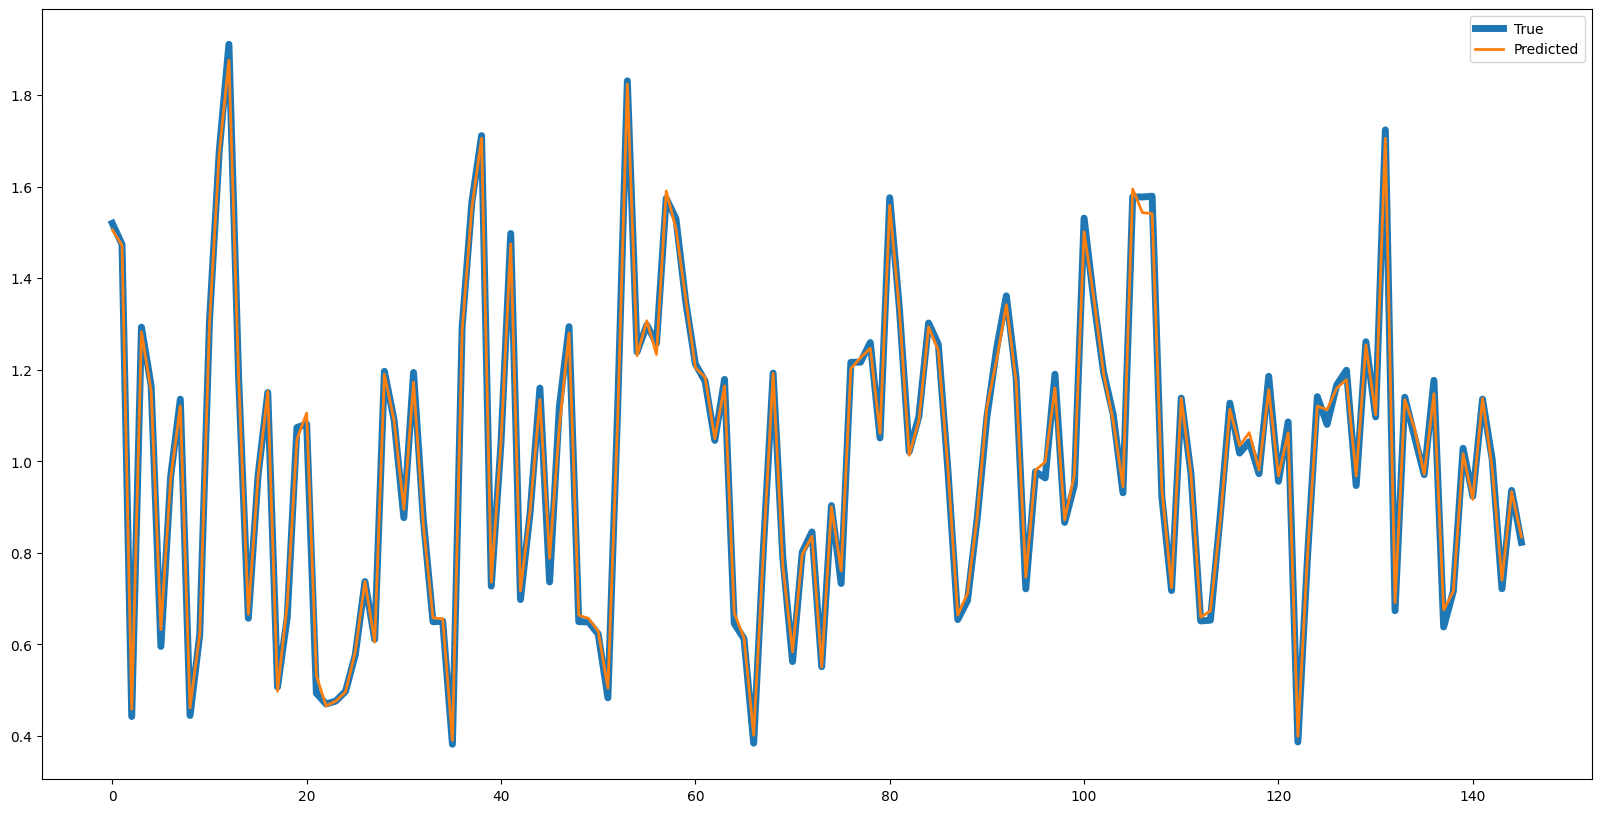

In [17]:
import xgboost as xgb
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3,random_state=21624)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE train: ', mse_train)
print('RMSE', np.sqrt(mse_train))
print('MSE test: ', mse_test)
print('RMSE', np.sqrt(mse_test))

test_diff_sign_pred = np.sign(np.diff(np.array(y_pred_test)))
test_diff_sign = np.sign(np.diff(np.array(y_test)))
same = np.sum(test_diff_sign_pred == test_diff_sign)
diff = np.sum(test_diff_sign_pred != test_diff_sign)
print('Same:',same, ' Diff:', diff)

feature_importances = model.feature_importances_
feature_importance = list(zip(new_columns, feature_importances))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=False)
feature_importance = dict(feature_importance)
print(feature_importance.keys())
plt.figure(figsize=(20, 10))
plt.plot(y_train[:,0], linewidth=5, label='True') 
plt.plot(y_pred_train[:,0], linewidth=2, label='Predicted')
plt.legend()
plt.show()


MSE train:  6.040494392427097e-07
RMSE 0.0007772061755047432
MSE test:  0.10389889587116902
RMSE 0.3223335165184797
Same: 39  Diff: 10

MSE train:  0.00028782123697871677
RMSE 0.016965295074908564
MSE test:  0.11101289516055854
RMSE 0.3331859768365988
Same: 33  Diff: 16



### 确认降维

MSE train1:  1.0160082819565212e-05
RMSE 0.0031874884814796136
MSE test1:  0.08035394278337082
RMSE 0.28346771030113965
Same: 34  Diff: 14
MSE train2:  2.398635843192374e-07
RMSE 0.0004897587000955036
MSE test2:  0.10421386695306711
RMSE 0.3228217262717414
Same: 35  Diff: 13


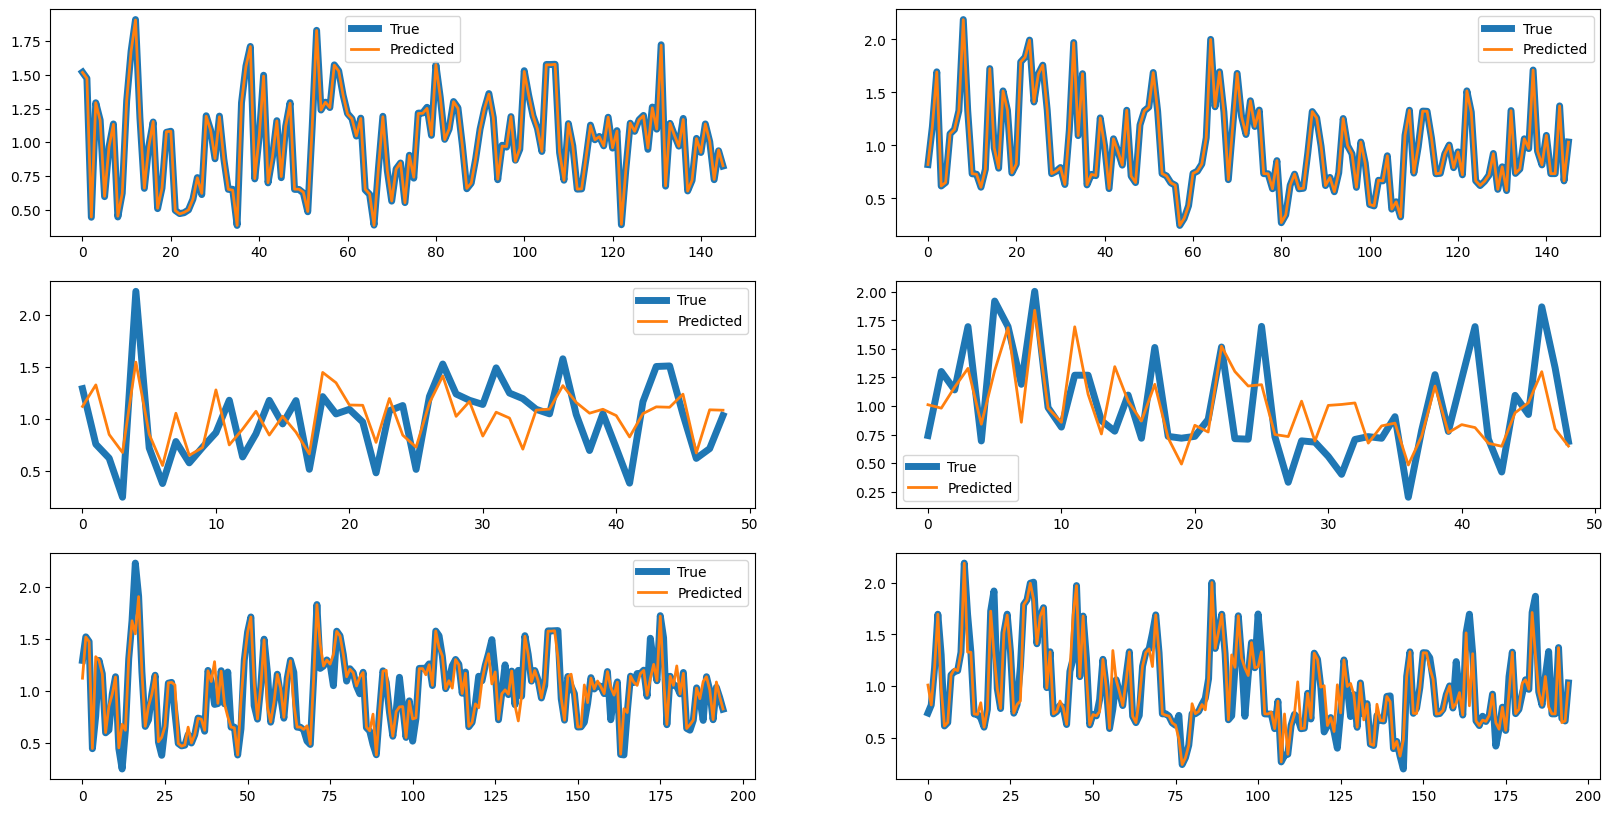

In [29]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=25)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_pca = pca.transform(X)
another_X_pca = pca.transform(another_X)

# X_train_pca = X_train
# X_test_pca = X_test
# X_pca = X
# another_X_pca = another_X


y_train_1 = y_train[:,0]
y_test_1 = y_test[:,0]
y_train_2 = y_train[:,1]
y_test_2 = y_test[:,1]

import xgboost as xgb
model1 = xgb.XGBRegressor(objective="reg:squarederror", subsample=0.8, random_state=21624,max_depth = 3)
model1.fit(X_train_pca, y_train_1)
y_pred_train_1 = model1.predict(X_train_pca)
y_pred_test_1 = model1.predict(X_test_pca)
mse_train_1 = mean_squared_error(y_train_1, y_pred_train_1)
mse_test_1 = mean_squared_error(y_test_1, y_pred_test_1)
print('MSE train1: ', mse_train_1)
print('RMSE', np.sqrt(mse_train_1))
print('MSE test1: ', mse_test_1)
print('RMSE', np.sqrt(mse_test_1))

test_diff_sign_pred_1 = np.sign(np.diff(np.array(y_pred_test_1)))
test_diff_sign_1 = np.sign(np.diff(np.array(y_test_1)))
same_1 = np.sum(test_diff_sign_pred_1 == test_diff_sign_1)
diff_1 = np.sum(test_diff_sign_pred_1 != test_diff_sign_1)
print('Same:',same_1, ' Diff:', diff_1)

model2 = xgb.XGBRegressor(objective="reg:squarederror",random_state=21624)
model2.fit(X_train_pca, y_train_2)
y_pred_train_2 = model2.predict(X_train_pca)
y_pred_test_2 = model2.predict(X_test_pca)
mse_train_2 = mean_squared_error(y_train_2, y_pred_train_2)
mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)
print('MSE train2: ', mse_train_2)
print('RMSE', np.sqrt(mse_train_2))
print('MSE test2: ', mse_test_2)
print('RMSE', np.sqrt(mse_test_2))

y_pred_all_1 = model1.predict(X_pca)
y_pred_all_2 = model2.predict(X_pca)

test_diff_sign_pred_2 = np.sign(np.diff(np.array(y_pred_test_2)))
test_diff_sign_2 = np.sign(np.diff(np.array(y_test_2)))
same_2 = np.sum(test_diff_sign_pred_2 == test_diff_sign_2)
diff_2 = np.sum(test_diff_sign_pred_2 != test_diff_sign_2)
print('Same:',same_2, ' Diff:', diff_2)
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(y_train_1, linewidth=5, label='True')
plt.plot(y_pred_train_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(y_train_2, linewidth=5, label='True')
plt.plot(y_pred_train_2, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 3)
plt.plot(y_test_1, linewidth=5, label='True')
plt.plot(y_pred_test_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 4)
plt.plot(y_test_2, linewidth=5, label='True')
plt.plot(y_pred_test_2, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 5)
plt.plot(Y[:,0], linewidth=5, label='True')
plt.plot(y_pred_all_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 6)
plt.plot(Y[:,1], linewidth=5, label='True')
plt.plot(y_pred_all_2, linewidth=2, label='Predicted')
plt.show()

<!-- 增加subsample = 0.4 -->
MSE train1:  7.211768373122049e-06
RMSE 0.002685473584513921
MSE test1:  0.10416380959895026
RMSE 0.3227441860033272
Same: 31  Diff: 17

<!-- 普通 -->
MSE train2:  2.398635843192374e-07
RMSE 0.0004897587000955036
MSE test2:  0.10421386695306711
RMSE 0.3228217262717414
Same: 35  Diff: 13

<!-- subsample = 0.8 -->
MSE train1:  1.5650873183181867e-07
RMSE 0.0003956118449083883
MSE test1:  0.0826308057086089
RMSE 0.28745574565245496
Same: 32  Diff: 16

MSE train2:  2.398635843192374e-07
RMSE 0.0004897587000955036
MSE test2:  0.10421386695306711
RMSE 0.3228217262717414
Same: 35  Diff: 13

<!-- max_depth = 3 -->
MSE train1:  1.0160082819565212e-05
RMSE 0.0031874884814796136
MSE test1:  0.08035394278337082
RMSE 0.28346771030113965
Same: 34  Diff: 14
MSE train2:  2.398635843192374e-07
RMSE 0.0004897587000955036
MSE test2:  0.10421386695306711
RMSE 0.3228217262717414
Same: 35  Diff: 13

Same: 147  Diff: 127
Same: 139  Diff: 135
MSE1: 0.17099337480120394
MSE2: 0.25311029257142714


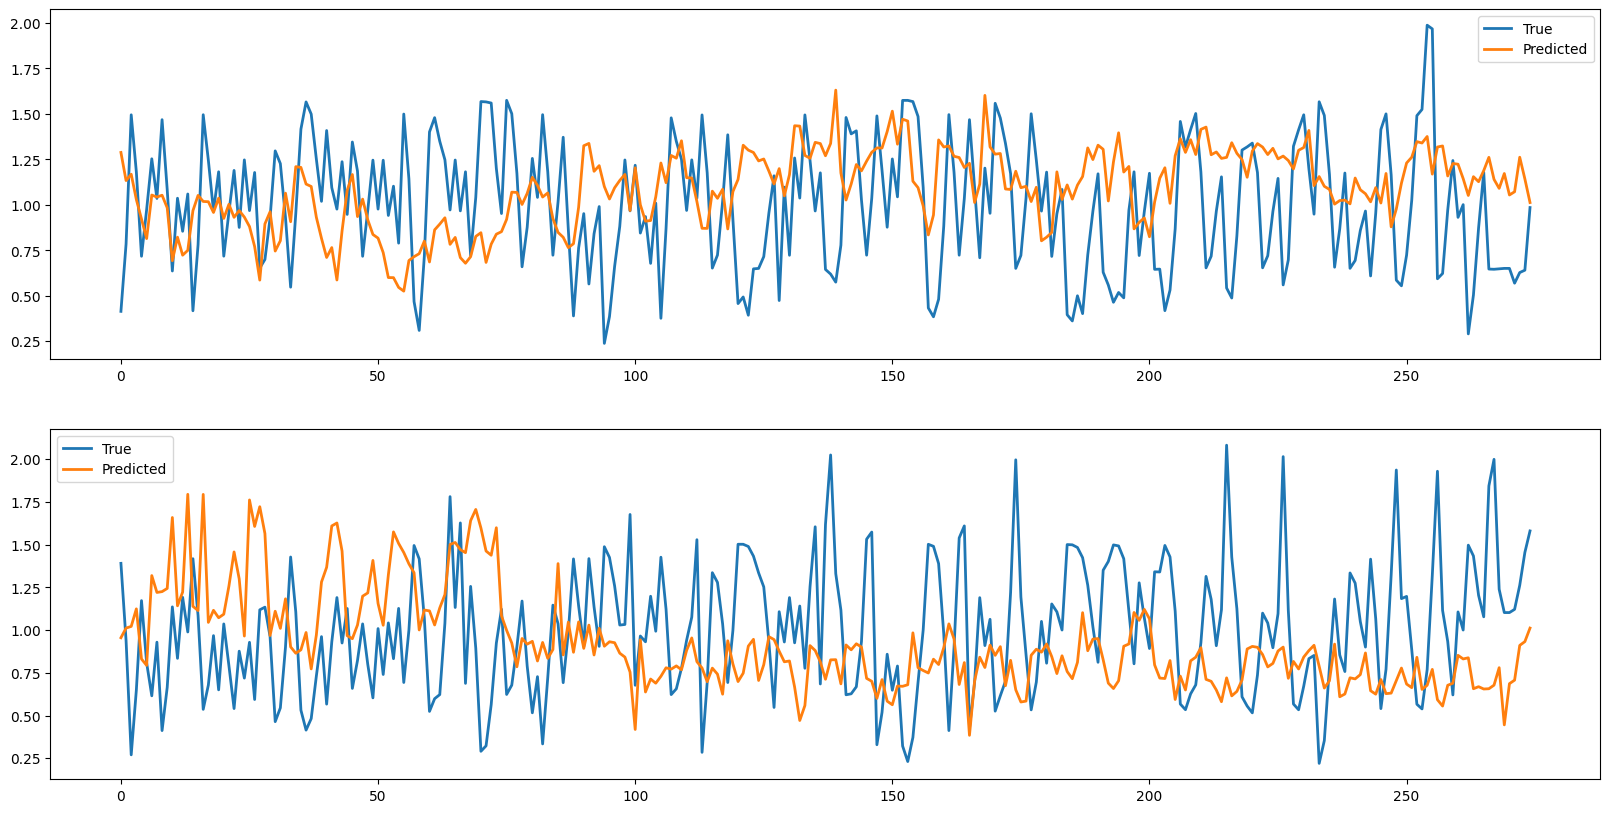

In [30]:
another_y_1 = another_Y[:,1]
another_y_2 = another_Y[:,0]
another_y_pred_1 = model1.predict(another_X_pca)
another_y_pred_2 = model2.predict(another_X_pca)

another_diff_sign_pred_1 = np.sign(np.diff(np.array(another_y_pred_1)))
another_diff_sign_pred_2 = np.sign(np.diff(np.array(another_y_pred_2)))
another_diff_sign_1 = np.sign(np.diff(np.array(another_y_1)))
another_diff_sign_2 = np.sign(np.diff(np.array(another_y_2)))
another_same_1 = np.sum(another_diff_sign_pred_1 == another_diff_sign_1)
another_diff_1 = np.sum(another_diff_sign_pred_1 != another_diff_sign_1)
another_same_2 = np.sum(another_diff_sign_pred_2 == another_diff_sign_2)
another_diff_2 = np.sum(another_diff_sign_pred_2 != another_diff_sign_2)
print('Same:',another_same_1, ' Diff:', another_diff_1)
print('Same:',another_same_2, ' Diff:', another_diff_2)
print('MSE1:', mean_squared_error(another_y_1, another_y_pred_1))
print('MSE2:', mean_squared_error(another_y_2, another_y_pred_2))


plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(another_y_1, linewidth=2, label='True')
plt.plot(another_y_pred_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(another_y_2, linewidth=2, label='True')
plt.plot(another_y_pred_2, linewidth=2, label='Predicted')
plt.legend()
plt.show()


<!-- 1 -->
Same: 141  Diff: 133
Same: 139  Diff: 135
MSE1: 0.20615820793505266
MSE2: 0.25311029257142714

Same: 141  Diff: 133
Same: 139  Diff: 135
MSE1: 0.1866769379215769
MSE2: 0.25311029257142714

Same: 147  Diff: 127
Same: 139  Diff: 135
MSE1: 0.17099337480120394
MSE2: 0.25311029257142714

### 预测

##### 最近邻

MSE train1:  0.05542819207205252
RMSE 0.2354319266201008
MSE test1:  0.09230129530390209
RMSE 0.30381128238415056
Same: 32  Diff: 16
MSE train2:  0.07336745142378082
RMSE 0.27086426752855536
MSE test2:  0.1027299984435066
RMSE 0.32051520781938975
Same: 33  Diff: 15


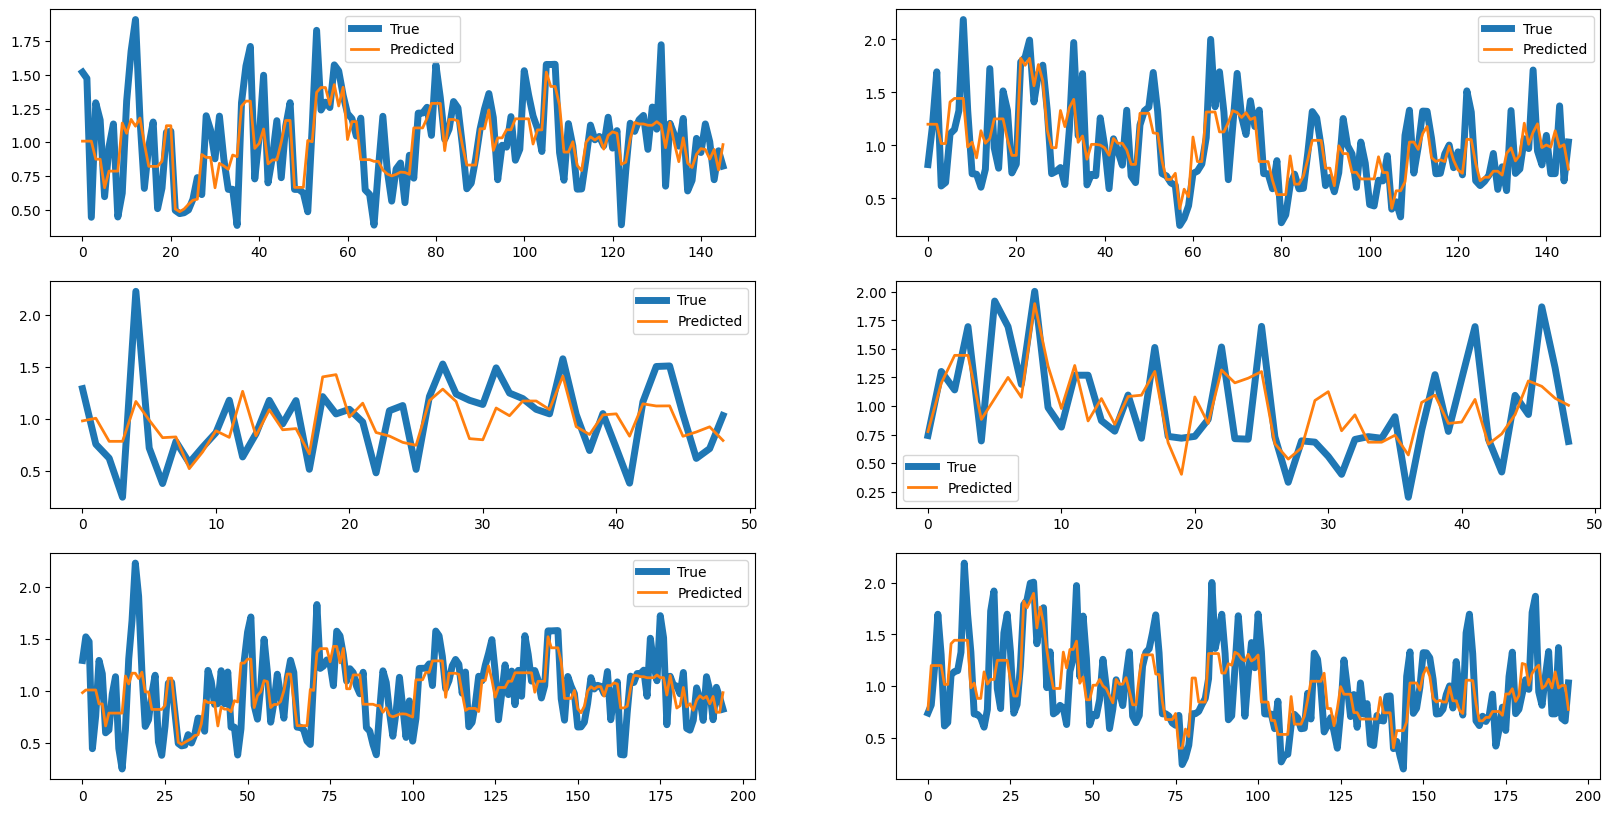

In [14]:
from sklearn.neighbors import KNeighborsRegressor
k = 4  # 选择最近邻的数量
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_pca = pca.transform(X)
y_train_1 = y_train[:,0]
y_test_1 = y_test[:,0]
y_train_2 = y_train[:,1]
y_test_2 = y_test[:,1]

model1 = KNeighborsRegressor(n_neighbors=k)
model1.fit(X_train_pca, y_train_1)
y_pred_train_1 = model1.predict(X_train_pca)
y_pred_test_1 = model1.predict(X_test_pca)
mse_train_1 = mean_squared_error(y_train_1, y_pred_train_1)
mse_test_1 = mean_squared_error(y_test_1, y_pred_test_1)
print('MSE train1: ', mse_train_1)
print('RMSE', np.sqrt(mse_train_1))
print('MSE test1: ', mse_test_1)
print('RMSE', np.sqrt(mse_test_1))

test_diff_sign_pred_1 = np.sign(np.diff(np.array(y_pred_test_1)))
test_diff_sign_1 = np.sign(np.diff(np.array(y_test_1)))
same_1 = np.sum(test_diff_sign_pred_1 == test_diff_sign_1)
diff_1 = np.sum(test_diff_sign_pred_1 != test_diff_sign_1)
print('Same:',same_1, ' Diff:', diff_1)

model2 = KNeighborsRegressor(n_neighbors=k)
model2.fit(X_train_pca, y_train_2)
y_pred_train_2 = model2.predict(X_train_pca)
y_pred_test_2 = model2.predict(X_test_pca)
mse_train_2 = mean_squared_error(y_train_2, y_pred_train_2)
mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)
print('MSE train2: ', mse_train_2)
print('RMSE', np.sqrt(mse_train_2))
print('MSE test2: ', mse_test_2)
print('RMSE', np.sqrt(mse_test_2))

y_pred_all_1 = model1.predict(X_pca)
y_pred_all_2 = model2.predict(X_pca)

test_diff_sign_pred_2 = np.sign(np.diff(np.array(y_pred_test_2)))
test_diff_sign_2 = np.sign(np.diff(np.array(y_test_2)))
same_2 = np.sum(test_diff_sign_pred_2 == test_diff_sign_2)
diff_2 = np.sum(test_diff_sign_pred_2 != test_diff_sign_2)
print('Same:',same_2, ' Diff:', diff_2)
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(y_train_1, linewidth=5, label='True')
plt.plot(y_pred_train_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(y_train_2, linewidth=5, label='True')
plt.plot(y_pred_train_2, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 3)
plt.plot(y_test_1, linewidth=5, label='True')
plt.plot(y_pred_test_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 4)
plt.plot(y_test_2, linewidth=5, label='True')
plt.plot(y_pred_test_2, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 5)
plt.plot(Y[:,0], linewidth=5, label='True')
plt.plot(y_pred_all_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(3, 2, 6)
plt.plot(Y[:,1], linewidth=5, label='True')
plt.plot(y_pred_all_2, linewidth=2, label='Predicted')
plt.show()

Same: 95  Diff: 179
Same: 94  Diff: 180
MSE1: 0.15033445449424612
MSE2: 0.20281267942468803


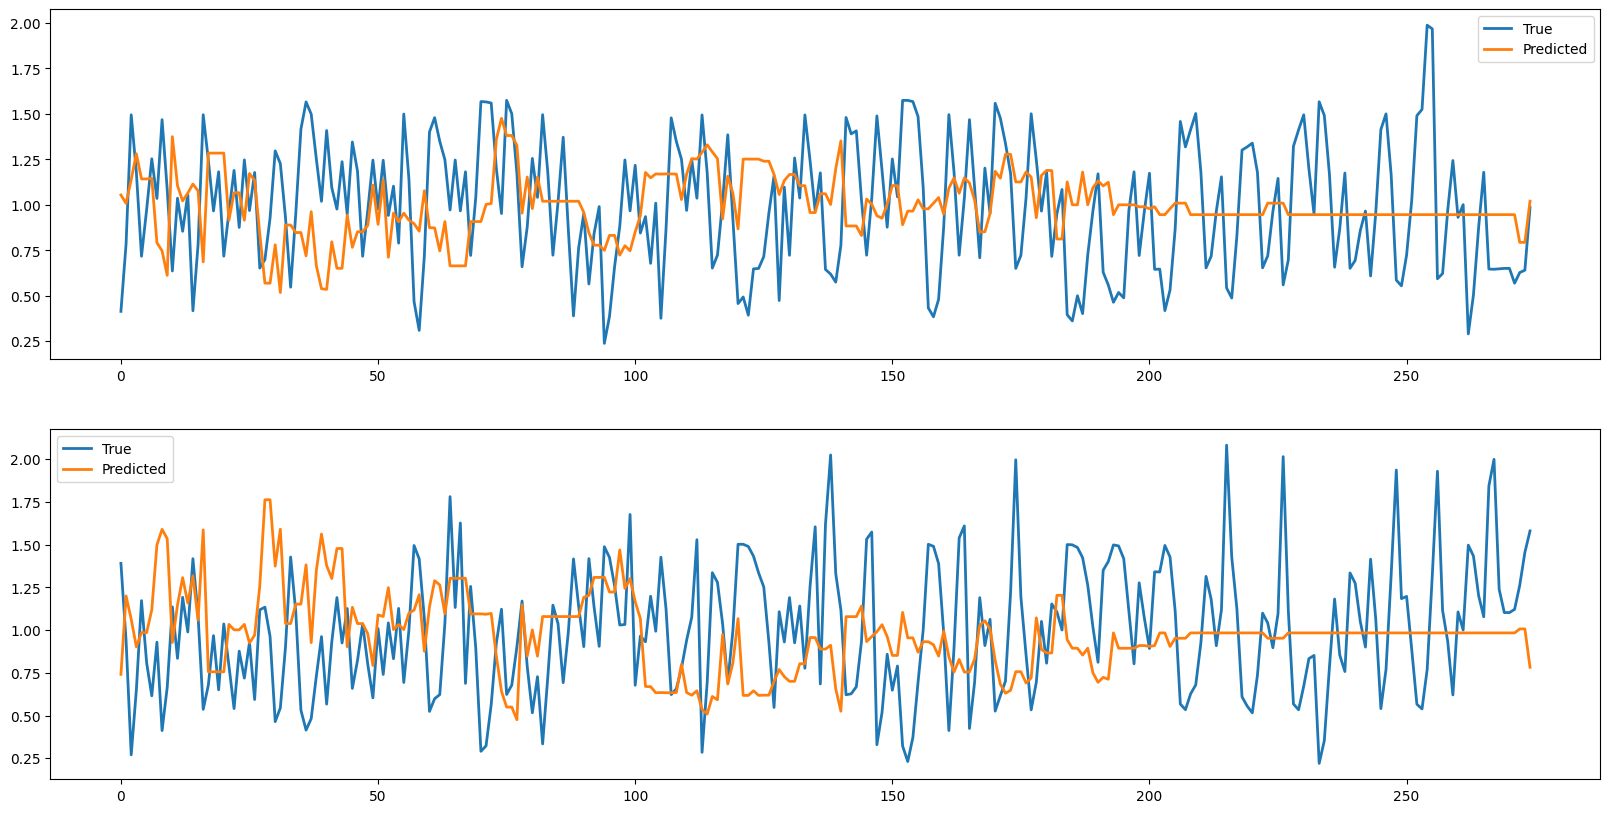

In [15]:
another_y_1 = another_Y[:,1]
another_y_2 = another_Y[:,0]
another_X_pca = pca.transform(another_X)
another_y_pred_1 = model1.predict(another_X_pca)
another_y_pred_2 = model2.predict(another_X_pca)

another_diff_sign_pred_1 = np.sign(np.diff(np.array(another_y_pred_1)))
another_diff_sign_pred_2 = np.sign(np.diff(np.array(another_y_pred_2)))
another_diff_sign_1 = np.sign(np.diff(np.array(another_y_1)))
another_diff_sign_2 = np.sign(np.diff(np.array(another_y_2)))
another_same_1 = np.sum(another_diff_sign_pred_1 == another_diff_sign_1)
another_diff_1 = np.sum(another_diff_sign_pred_1 != another_diff_sign_1)
another_same_2 = np.sum(another_diff_sign_pred_2 == another_diff_sign_2)
another_diff_2 = np.sum(another_diff_sign_pred_2 != another_diff_sign_2)
print('Same:',another_same_1, ' Diff:', another_diff_1)
print('Same:',another_same_2, ' Diff:', another_diff_2)
print('MSE1:', mean_squared_error(another_y_1, another_y_pred_1))
print('MSE2:', mean_squared_error(another_y_2, another_y_pred_2))


plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(another_y_1, linewidth=2, label='True')
plt.plot(another_y_pred_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(another_y_2, linewidth=2, label='True')
plt.plot(another_y_pred_2, linewidth=2, label='Predicted')
plt.legend()
plt.show()


##### BP神经网络

In [16]:
# import keras

# model = keras.Sequential([
#     keras.layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.Dense(1, activation='linear')
# ])
# model.compile(optimizer='adam', loss='mean_squared_error')
# for i in range(20):
#     model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
# loss_train = model.evaluate(X_train, y_train)
# loss_test = model.evaluate(X_test, y_test)
# print('MSE train',loss_train)
# print('RMSE', np.sqrt(loss_train))
# print('MSE test',loss_test)
# print('RMSE', np.sqrt(loss_test))
# y_pred_test = model.predict(X_test)

# test_diff_sign_pred = np.sign(np.diff(np.array(y_pred_test)))
# test_diff_sign = np.sign(np.diff(np.array(y_test)))
# same = np.sum(test_diff_sign_pred == test_diff_sign)
# diff = np.sum(test_diff_sign_pred != test_diff_sign)
# print('Same:',same, ' Diff:', diff)
